# TP3 :  Discrétisation de l'équation de la chaleur

In [1]:
import numpy as np
import math

import scipy.sparse as sparse
import scipy.sparse.linalg

from scipy.integrate import quad

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

### Equation de la chaleur :
On se place dans le domaine temporel $]0,T[$ ($T>0$) et spatial $]0,1[$.
On souhaite discrétiser l'équation de la chaleur avec des conditions aux limites de Dirichlet homogènes :
$$\dfrac{\partial u}{\partial t} - \dfrac{\partial^2 u}{\partial x^2} = f \text{ dans } ]0,T[ \times ]0,1[,$$
$$u(t,0) = u(t,1) = 0 \text{ pour } t \in ]0,T[,$$
$$u(0,x) = u_0(x) \text{ pour } x \in ]0,1[,$$
où $f$ est une fonction de $]0,T[ \times ]0,1[$ donnée et $u_0$ est une fonction donnée de $]0,1[$.

### Discrétisation du domaine :
On discrétise le domaine spatial $]X_{\text{min}},X_{\text{max}}[$ par $M>0$ sous-intervalles (dans la suite $X_{\text{min}}=0$ et $X_{\text{max}}=1$). 
Les points correspondant à cette discrétisation sont les $x_i = X_{\text{min}} + i h_x$ avec $h_x = \frac{X_{\text{max}} - X_{\text{min}}}{M}$ ($0 \leq i \leq M$). 
On discrétise le domaine temporel $]0,T[$ par $N>0$ sous-intervalles.
Les points correspondants sont les $t_n = n h_t$ avec $h_t = \frac{T}{N}$.
On pourra calculer ces points avec les commandes suivantes :

In [2]:
M=2
print(np.linspace(0,1,M+1))

T=2
N=2
print(np.linspace(0,T,N+1))

[0.  0.5 1. ]
[0. 1. 2.]


### Solution exacte :

Pour étudier la convergence de nos schémas numériques, on propose la solution suivante :
$$u(t,x) = \cos(t)\sin(\pi x) . $$

La fonction second membre correspondante est
$$f(t,x) = (\pi^2 \cos(t)-\sin(t)) \sin(\pi x) ,$$
et la donnée initiale est
$$ u_0(x) = \sin(\pi x) . $$

In [3]:
M_PI = math.pi

# sol exacte
def u_ex(t,x):
    return math.cos(t)*math.sin(M_PI * x)

# fonction second membre
def f(t,x):
    return (M_PI**2 * math.cos(t) - math.sin(t)) * math.sin(M_PI * x)

# donnée initiale
def u_0(x):
    return math.sin(M_PI*x)


### Formulation variationnelle
La formulation variationnelle associée est : pour tout $t \in [0,T]$, on veut trouver $u(t,.) \in H^1_0(0,1)$
telle que pour tout $v \in H^1_0(0,1)$ on ait 
$$ \int_0^1 \dfrac{\partial u}{\partial t}(t,x) v(x) + \dfrac{\partial u}{\partial x}(t,x) v'(x) \; \mathrm{d}x
= \int_0^1 f(t,x) v(x) \; \mathrm{d}x$$
On va discrétiser ce problème en espace puis en temps pour obtenir le schéma à coder.

### Semi-discrétisation en espace
On utilise une discrétisation éléments finis en espace.
Le problème devient: pour tout $t \in [0,T]$, trouver $u_h(t,.) \in V_{h0}$ telle que pour tout $v_h \in V_{h0}$
on ait
$$\int_0^1 \dfrac{\partial u_h}{\partial t}(t,x) v_h(x) + \dfrac{\partial u_h}{\partial x}(t,x) v_h'(x) \; \mathrm{d}x
= \int_0^1 f(t,x) v_h(x) \; \mathrm{d}x$$
Ici, l'espace $V_{h0}$ est l'espace éléments finis vu en cours qui approche $H^1_0(0,1)$.

### Discrétisation complète
On va maintenant approcher la dérivée en temps par la méthode d'Euler :
$$ \dfrac{\partial u_h}{\partial t}(t_{n+1},x) \simeq \dfrac{u_h(t_{n+1},x) - u_h(t_n,x)}{h_t}$$

On obtient donc le schéma suivant :

$\bullet$ On initialise la solution numérique par $u_h^0 \in V_{h0}$ défini par
$$u_h^0(x_j) = u_0(x_j) \qquad 1 \leq j \leq M-1$$
$\bullet$ puis, pour $0 \leq n \leq N-1$, on met à jour la solution en trouvant la solution du problème variationnel:
Trouver $u_h^{n+1} \in V_{h0}$ tel que pour tout $v_h \in V_{h0}$ on ait
$$\int_0^1 u_h^{n+1}(x) v(x) + h_t \dfrac{\partial u_h^{n+1}}{\partial x}(x) v_h'(x) \; \mathrm{d}x
= \int_0^1 u_h^n(x) v_h(x) + h_t f(t_{n+1},x) v_h(x) \; \mathrm{d}x$$

### Ecriture algébrique du problème
On peut montrer que la marche en temps se fait en pratique en résolvant le système linéaire:
$$ (\mathcal{M} + h_t A) U^{n+1} = \mathcal{M} U^n + h_t F^{n+1}$$
où $U^n$ contient les coordonnées de la solution dans la base canonique (les valeurs de $u_h^n$ aux points $x_j$),
le vecteur $F$ est défini par
$$ F_i^{n+1} = \int_0^1 f(t_{n+1},x) \Phi_i(x) \; \mathrm{d}x$$
la matrice de raideur $A$ et la matrice de masse $\mathcal{M}$ sont définies (dans notre cas 1d) par
$$ A = \dfrac1{h_x}
\begin{pmatrix}
2 & -1 & & (0)
\\
-1 & \ddots & \ddots
\\
   & \ddots & \ddots & -1
\\
(0)&& -1 & 2
\end{pmatrix}
\quad \text{et} \quad
\mathcal{M} = \dfrac{h_x}6
\begin{pmatrix}
4 & 1 & & (0)
\\
1 & \ddots & \ddots
\\
   & \ddots & \ddots & 1
\\
(0)&& 1 & 4
\end{pmatrix}$$

In [4]:
# coder une fonction renvoyant la matrice de raideur A
def mat_A(M):
    h = 1/M
    
    row = list()
    col = list()
    data = list()
    
    # A_0,0
    row.append((0))
    col.append((0))
    data.append(2)
    
    # A_0,1
    row.append((0))
    col.append((1))
    data.append(-1)
    
    #loop
    for i in range(1,M-2):
    
        # A_i,i = qque chose (exemple)
        row.append((i))
        col.append((i))
        data.append( 2 )  
    
        # A_i,i-1 = autre chose (exemple)
        row.append((i))
        col.append((i-1))
        data.append( -1 )
    
        # A_i,i+1 = encore autre chose
        row.append((i))
        col.append((i+1))
        data.append( -1 )

    # A_{M-2},{M-3}
    row.append((M-2))
    col.append((M-3))
    data.append(-1)
    
    # A_{M-2},{M-2}
    row.append((M-2))
    col.append((M-2))
    data.append(2)
    
    row = np.array(row)
    col = np.array(col)
    data = np.array(data)      
    A = (sparse.coo_matrix((data, (row, col)), shape=(M-1, M-1))).tocsr()
    return A/h

In [5]:
# coder une fonction renvoyant la matrice de masse M
def mat_M(M):
    h = 1/M
    
    row = list()
    col = list()
    data = list()
    
    # A_0,0
    row.append((0))
    col.append((0))
    data.append(4)
    
    # A_0,1
    row.append((0))
    col.append((1))
    data.append(1)
    
    #loop
    for i in range(1,M-2):
    
        # A_i,i = qque chose (exemple)
        row.append((i))
        col.append((i))
        data.append( 4 )  
    
        # A_i,i-1 = autre chose (exemple)
        row.append((i))
        col.append((i-1))
        data.append( 1 )
    
        # A_i,i+1 = encore autre chose
        row.append((i))
        col.append((i+1))
        data.append( 1 )

    # A_{M-2},{M-3}
    row.append((M-2))
    col.append((M-3))
    data.append(1)
    
    # A_{M-2},{M-2}
    row.append((M-2))
    col.append((M-2))
    data.append(4)
    
    row = np.array(row)
    col = np.array(col)
    data = np.array(data)      
    A = (sparse.coo_matrix((data, (row, col)), shape=(M-1, M-1))).tocsr()
    return (h/6)*A

In [6]:
# coder une fonction renvoyant la valeur de la fonction de base \Phi_i en x
def Phi(M,j,x):
    h = 1./M
    xj = j*h
    if x < xj-h:
        return 0
    if x < xj:
        return (x-xj+h)/h
    if x < xj+h:
        return (xj+h-x)/h
    return 0

In [7]:
# coder une fonction calculant (au moins de maniere approchee) le vecteur F^{n+1}
def RHS_F(N,M,n):
    F = np.zeros(M-1)
    h_t = T/N
    h_x = 1./M
    for i in range(0,M-1):
        xi = (i+1)*h_x
        def fPhi(x):
            return f((n+1)*h_t,x) * Phi(M,i+1,x)
        F[i] = quad(fPhi, xi-h_x, xi+h_x)[0]
    return F

In [20]:
# coder une fonction appliquant le schema donne ci-dessus
# cette fonction renverra la solution numerique dans un tableau a double entree (temps et espace)
# on rappelle que le produit matrice-vecteur A*B se fait avec A.dot(B)
def schema_EF(N,M):
    # discretisation du domaine
    X = np.linspace(0,1,M+1)
    h_t = T/N
    
    # initialisation du vecteur solution
    U = np.zeros((N+1,M+1))
    for j in range(1,M+1):
        U[0,j] = u_0(X[j])
        
    # calcul des matrices
    mA = mat_A(M)
    mM = mat_M(M)
    mSyst = mM + h_t*mA
    
    # boucle en temps
    for n in range(N):
        # calcul du second membre
        F = RHS_F(N,M,n)
        RHS = mM.dot(U[n,1:M]) + h_t * F
        # resolution du systeme lineaire
        U[n+1,1:M] = sparse.linalg.spsolve(mSyst, RHS)
        
    return U

### Représentation de la solution
Tracer la solution au temps final obtenue numériquement et la comparer avec la solution exacte.

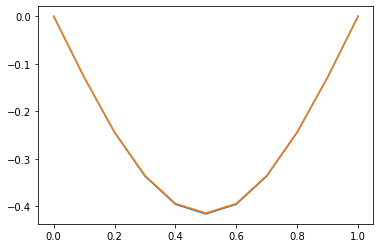

In [21]:
# comparer solution exacte et approchee au temps final
def graph_sol(M,N,u_ex):
    X = np.linspace(0,1,M+1)
    sol_ex = np.zeros(M+1)
    for i in range(1,M):
        sol_ex[i] = u_ex(T,X[i])
    
    sol_EF = schema_EF(N,M)[N,:]
    
    plt.plot(X,sol_ex)
    plt.plot(X,sol_EF)
    plt.show()

graph_sol(10,10,u_ex)

### Tests de convergence
Retrouver numériquement l'ordre de convergence de la méthode en norme
$$ \max_{\substack{0 \leq n \leq N \\ 0 \leq j \leq M}} |u(t_n,x_j) - u_h^n(x_j)| .$$

On se placera dans le cas $N=M$ pour simplifier.

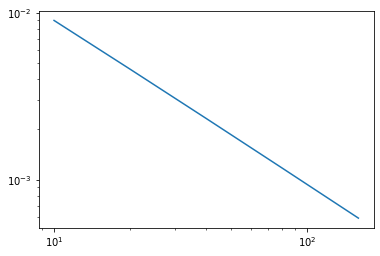

In [22]:
# tracer l'erreur generee par la methode en fonction du pas de discretisation (echelle log-log)
# on prendra M=N

liste_M = [10,20,40,80,160]
liste_err = []

for M in liste_M:
    X = np.linspace(0,1,M+1)
    N = M
    h_t = T/N
        
    # solution elements finis
    U = schema_EF(M,N)
    
    # solution exacte
    U_ex = np.zeros((N+1,M+1))
    for n in range(N+1):
        for j in range(1,M):
            U_ex[n,j] = u_ex(n*h_t,X[j])
            
    # calcul de l'erreur
    err = 0
    for n in range(N+1):
        for j in range(1,M):
            err_nj = abs(U[n,j]-U_ex[n,j])
            if(err_nj > err): 
                err = err_nj
    
    liste_err.append(err)


plt.plot(liste_M, liste_err)
plt.loglog()
plt.show()

Quel ordre de convergence obtenez-vous ?

Votre réponse :

In [ ]:
# ordre 1